# Разведочный анализ данных

## Импорты

In [1]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Загрузка данных

Данные в формате tskv (Tab separated key-value)

In [ ]:
# os.makedirs('../data', exist_ok=True)
# !wget https://github.com/yandex/geo-reviews-dataset-2023/raw/refs/heads/master/geo-reviews-dataset-2023.tskv -q -O ../data/data.tskv

## Создание Pandas DataFrame

In [2]:
# Чтение файла по строкам
with open("../data/data.tskv", "r", encoding="utf-8") as file:
    lines = file.readlines()

# Парсим каждую строку
parsed_data = []
for line in lines:
    # Разбиваем строку на Dict[key, value]
    line_dict = dict(item.split("=", 1) for item in line.split("\t"))
    parsed_data.append(line_dict)

# Преобразуем в DataFrame
df = pd.DataFrame(parsed_data)
# Приведём оценки из object в числовой формат
df["rating"] = df["rating"].apply(lambda x: np.int8(float(x)))
df

,address,name_ru,rating,rubrics,text
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ..."
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я..."
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...
...,...,...,...,...,...
499995,"Москва, Южный административный округ, район Би...",Бирюлёво-Пассажирская,4,Железнодорожная станция,"Охрана кривая но добрая, двери не закрываются ..."
499996,"Москва, Южный административный округ, район Би...",Бирюлёво-Пассажирская,4,Железнодорожная станция,По сравнению со многими современными платформа...
499997,"Новосибирск, Коммунистическая улица, 48А",NaN,5,"Бар, паб","Приятная атмосфера, прекрасное вино, волшебная..."
499998,"Астраханская область, Харабалинский район",Сарай-Бату,5,Достопримечательность,Был с семьёй 13.06.23 Отличное место. Рекоменд...


## Конвертация в формат CSV

In [ ]:
# df.to_csv("../data/data.csv", index=False)
# df = pd.read_csv("../data/data.csv")

## Работа с пропусками

In [3]:
df.isna().sum()

address      0
name_ru    970
rating       0
rubrics      0
text         0
dtype: int64

Выводы:

* Пропуски содержатся в названии места. Остальные параметры без пропусков.
* Такие пропуски лучше оставить. Модель дожна знать что делать, если название места не было передано в запросе.
* Заполним пустой строкой.

In [4]:
df["name_ru"] = df["name_ru"].fillna("")
df.isna().sum()

address    0
name_ru    0
rating     0
rubrics    0
text       0
dtype: int64

In [5]:
df[df["rating"] == 0]

,address,name_ru,rating,rubrics,text
1907,"Республика Карелия, Суоярви, улица Шельшакова, 1",Гостиница Карелия,0,Гостиница,"Гостиница расположенна удобно, если отремонтир..."
2165,"Кемерово, улица Тухачевского, 12",Светофор,0,Магазин автозапчастей и автотоваров;Автоаксесс...,Это мой любимый магазин с запчастями. Можно вс...
3584,"Краснодарский край, Анапа, улица Пушкина, 30",Кубань,0,Санаторий,"Нет растительного масла для салата, нет зубочи..."
3615,"Краснодарский край, Туапсинский район, Новомих...",Счастливый Хотей,0,Гостиница,"Все довольны, и взрослые и дети.\nВкусная еда...."
6389,"Ленинградская область, Выборг, улица Мира, 8А",Атриум,0,Торговый центр,"Большой выбор, очень грамотно и удобно разложе..."
...,...,...,...,...,...
482054,"посёлок городского типа Сириус, Набережная ули...",Ем и ем,0,Столовая;Быстрое питание;Доставка еды и обедов,Отличная столовая ходим переодически по сравне...
483488,"Кабардино-Балкарская Республика, Нальчик, улиц...",Амбассадор,0,Ресторан;Доставка еды и обедов,На днях посетили с семьёй ресторан Амбассадор....
486941,"Свердловская область, Екатеринбург, улица Цвил...",Рими,0,Мебель для кухни;Мебель на заказ;Гардеробные с...,Кухни европейского качества. Хорошее обслужива...
495253,"Санкт-Петербург, Полтавская улица, 3",Добрый Грузин,0,Ресторан;Доставка еды и обедов;Банкетный зал,"Очень вкусно готовят. Мясо шикарное, шашлык, х..."


Выводы:

* Видим, что есть нулевые рейтинги и, при этом, положительное текстовое описание. Это тоже пропуски в данных. Всего 200 строк.
* Таких пропусков немного, а заполнение будет достаточно трудоёмким, поэтому их лучше просто удалить из датасета.

In [6]:
df = df[~(df["rating"] == 0)]
df.shape

(499800, 5)

Выводы:

* Данные очищены от пропусков.

## Баланс классов

Не смотря на то, что у наc задача генерации текста, текстовые описания носят в том числе и эмоциональный окрас, выражающийся оценкой `rating`. Можно сказать, что тексты классифицируются по тональности.

In [7]:
df["rating"].value_counts().apply(lambda x: round(x / df.shape[0], 2))

rating
5    0.78
4    0.08
1    0.07
3    0.04
2    0.02
Name: count, dtype: float64

Выводы:

* Есть значительный дисбаланс. Положительные отзывы занимают 86% от всех отзывов.

## Анализ длин текстов

Дополним DataFrame длинами текстов.

In [8]:
df_copy = df.copy()
df_copy["length"] = df["text"].apply(lambda x: len(x))
df_copy.head()

,address,name_ru,rating,rubrics,text,length
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...,538
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ...",159
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я...",486
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...,143
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...,374


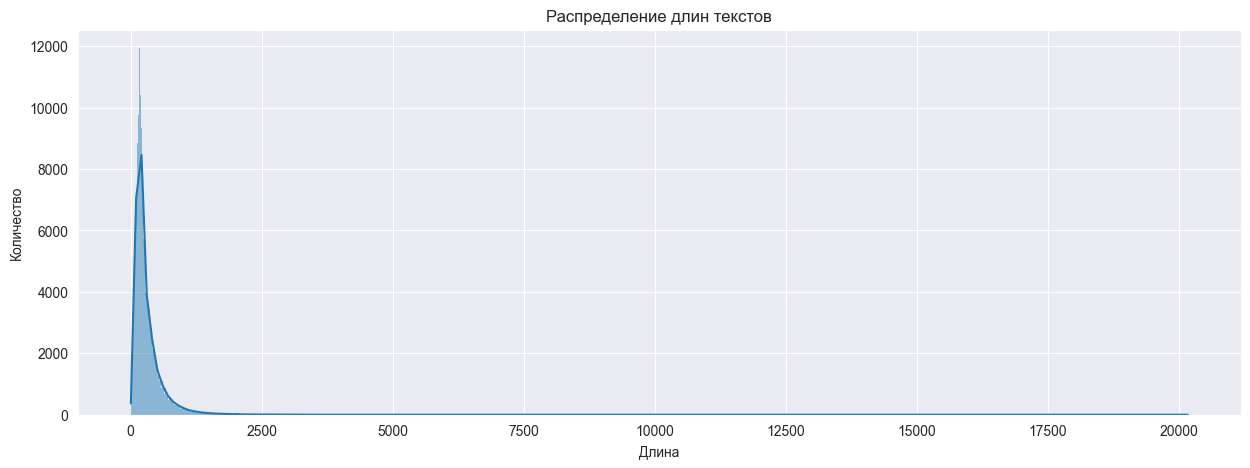

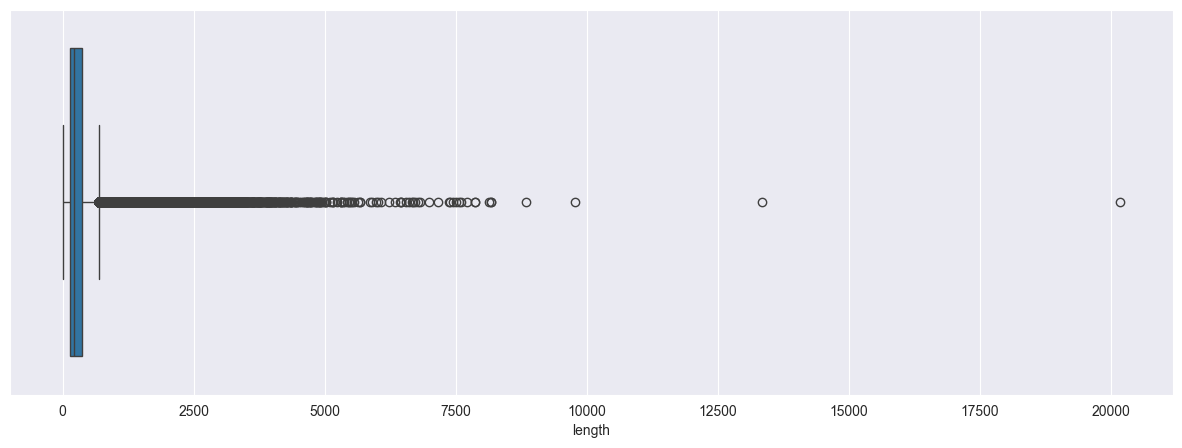

In [9]:
sns.set_style("darkgrid")


def length_distribution(lengths, name):
    plt.figure(figsize=(15, 5))
    sns.histplot(x=lengths, kde=True)
    plt.xlabel("Длина")
    plt.ylabel("Количество")
    plt.title(name)
    plt.show()

    plt.figure(figsize=(15, 5))
    sns.boxplot(x=lengths)
    plt.show()


length_distribution(df_copy["length"], "Распределение длин текстов")

In [10]:
df_copy[df_copy["length"] > 10000]["text"].values

array(['Que si, que no...\\nМногажды бывал в этом замечательном отеле, и с каждым разом всё больше и больше эта песня про тупящего влюблённого, являющаяся гимном отеля, всё точнее и точнее описывает качество отдыха. Вообще, этот гимн противоречиям максимально отражает происходящее с Вами на отдыхе в Ялта Интурист.\\nНачинается знакомство с особенностями сервиса со службы размещения (это те, кого называют ресепшн). Приветливость сотрудников на стойке регистрации можно выделить отдельно, Вас всегда встретят с улыбкой, всё расскажут и ответят на Ваши вопросы при заселении, но на чемпионате мира по созданию очередей, они без особого труда возьмут второе место (первое – без шансов конкурентам у транспортной безопасности терминала Аэроэкспресс в Шереметьево). Специальный удобный трансфер быстро перемещает десятки гостей из аэропорта и вокзала в очередь на заселение, где на 6 стойках регистрации работают всего один или два сотрудника. Господа, это, же, элементарно: на время прибытия трансферо

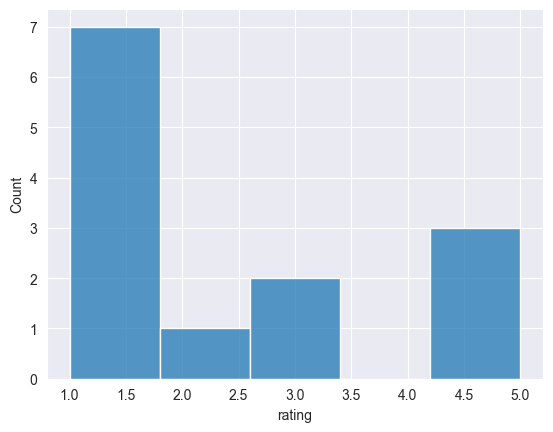

In [11]:
sns.histplot(x=df_copy[df_copy["length"] > 7500]["rating"])
plt.show()

Выводы:

* Выбросов нет. Есть длинные обстоятельные обзоры.
* Среди длинных обзоров немного больше отрицательных.

## Сохранение подготовленных данных

In [12]:
os.makedirs('../data/prepared', exist_ok=True)
df.to_csv("../data/prepared/data.csv", index=False)

### Количество уникальных слов и ТОП самых часто встречающихся слов и словосочетаний

In [177]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt

# Исключение строк с NaN из DataFrame
ndf = df.dropna()

# Преобразование текста к нижнему регистру и удаление ненужных символов
ndf['text'] = ndf['text'].astype(str).str.lower().apply(lambda x: re.sub(r'[^\w\s]', '', x))


C:\Users\Alex\AppData\Local\Temp\ipykernel_9688\2425363137.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf['text'] = ndf['text'].astype(str).str.lower().apply(lambda x: re.sub(r'[^\w\s]', '', x))


In [178]:
# Создание словаря для подсчета слов
word_count = Counter()


In [179]:
for text in ndf['text']:
    words = [w for w in text.split() if isinstance(w, str)]
    word_count.update(words)

In [180]:
# Получение количества уникальных слов
unique_words = len(word_count)

# Получение топ-20 слов
top_words = word_count.most_common(20)

In [181]:
# Получение топ-20 словосочетаний
all_text = ' '.join(ndf['text'])
all_words = re.findall(r'\b\w+\b', all_text.lower())
bigrams = [' '.join(all_words[i:i+2]) for i in range(len(all_words)-1)]
top_bigrams = Counter(bigrams).most_common(20)[:20]

def plot_top_words(words, title):
    plt.figure(figsize=(15, 5))
    plt.bar(range(len(words)), [word[1] for word in words])
    plt.xticks(range(len(words)), [word[0] for word in words], rotation=45)
    plt.title(title)
    plt.xlabel('Слово/словосочетание')
    plt.ylabel('Частота')
    plt.tight_layout()
    plt.show()

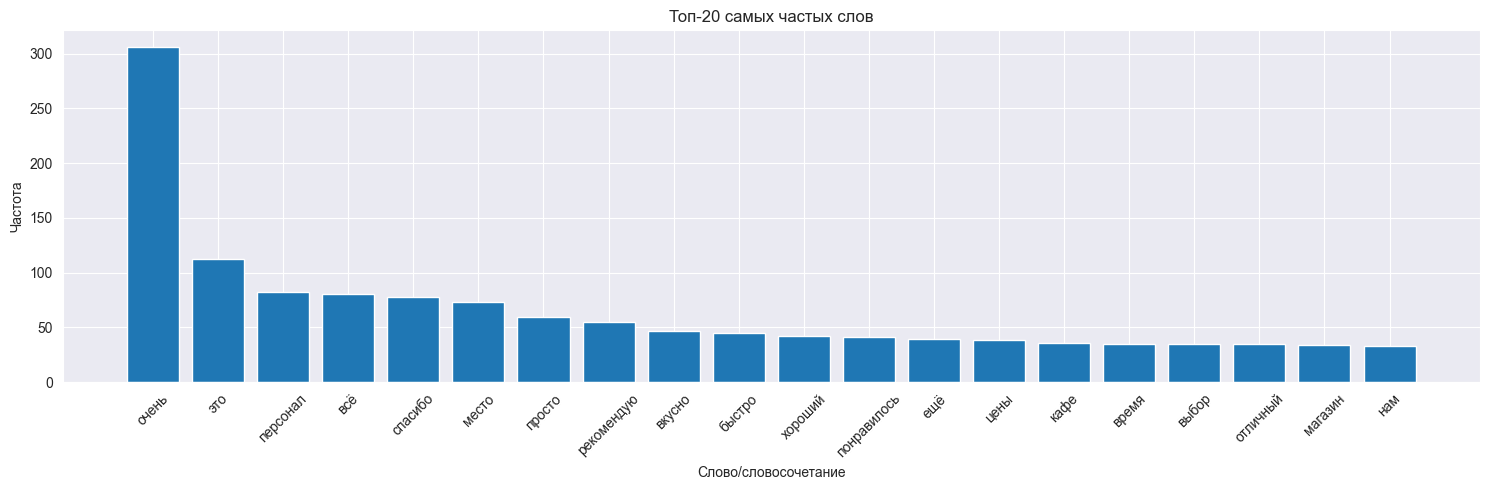

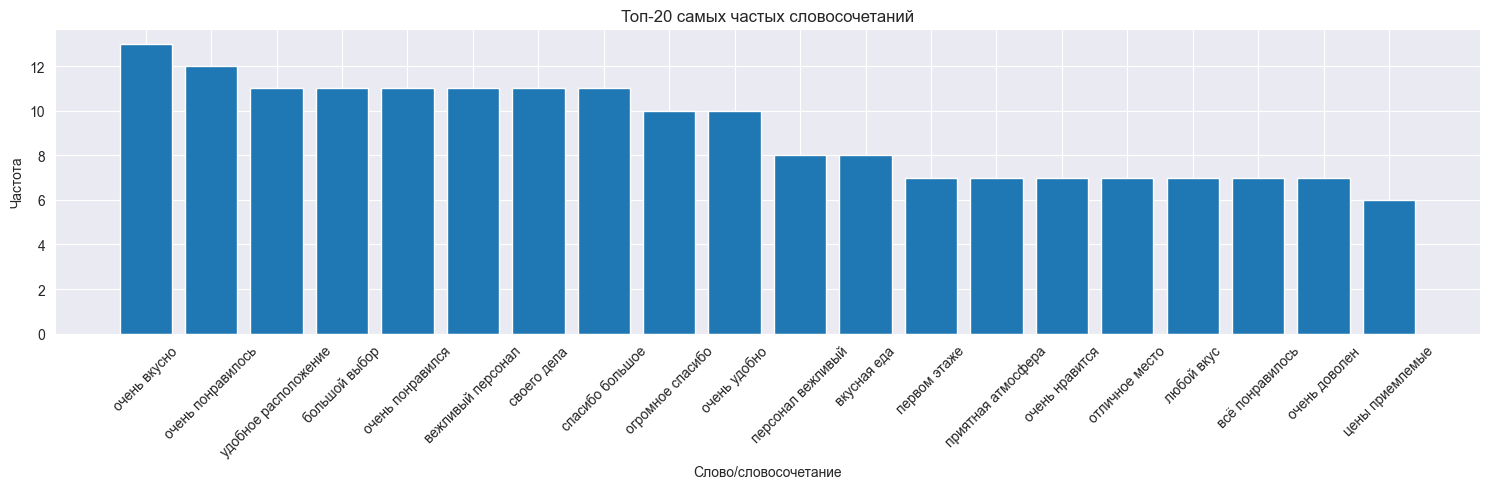

In [ ]:
# Визуализация топ-20 слов
plot_top_words(top_words, "Топ-20 самых частых слов")

# Визуализация топ-20 словосочетаний
plot_top_words(top_bigrams, "Топ-20 самых частых словосочетаний")

In [183]:
print(f"Количество уникальных слов: {unique_words}")
print("Топ-20 слов:")
for word, count in top_words:
    print(f"{word}: {count}")
print("\nТоп-20 словосочетаний:")
for bigram, count in top_bigrams:
    print(f"{bigram}: {count}")

Количество уникальных слов: 7951
Топ-20 слов:
очень: 306
это: 112
персонал: 82
всё: 80
спасибо: 78
место: 73
просто: 59
рекомендую: 55
вкусно: 47
быстро: 45
хороший: 42
понравилось: 41
ещё: 39
цены: 38
кафе: 36
время: 35
выбор: 35
отличный: 35
магазин: 34
нам: 33

Топ-20 словосочетаний:
очень вкусно: 13
очень понравилось: 12
удобное расположение: 11
большой выбор: 11
очень понравился: 11
вежливый персонал: 11
своего дела: 11
спасибо большое: 11
огромное спасибо: 10
очень удобно: 10
персонал вежливый: 8
вкусная еда: 8
первом этаже: 7
приятная атмосфера: 7
очень нравится: 7
отличное место: 7
любой вкус: 7
всё понравилось: 7
очень доволен: 7
цены приемлемые: 6


#### Выводы:

<ul>
    <li>Часто встречающиеся слова могут указывать на популярные темы или характеристики, которые пользователи ценят в отзывах. Например, слова "вкусно", "персонал", "место" могут быть ключевыми для оценки общего впечатления.</li>
    <li>Слова, связанные с сервисом (например, "персонал", "цены") могут быть важны для оценки качества обслуживания.</li>
    <li>Географические термины (например, "кафе", "время") могут помочь в локализации отзывов.</li>
    <li>Словосочетания могут раскрывать более конкретные характеристики или опыты пользователей. Например, "очень вкусно", "очень понравилось" могут быть критериями для оценки.</li>
    <li>Сочетания слов могут указывать на типичные проблемы или преимущества, о которых пользователи говорят.</li>
    <li>Словосочетания могут помочь в генерации более конкретных и детальных отзывов.</li>
</ul>